*This notebook, `summary.ipynb`, contains analysis of the open-coding processes itself. It depends upon CSV files generated by `notebook-search.ipynb`.*

# Import data and modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

%autosave 0

Autosave disabled


## Import codes

The cell below recursively searches the `notebooks/` directory for files with a `.html.pdf` extension. These are PDF printouts of computational notebooks and scripts that I coded using the comments feature in [Adobe Acrobat DC](https://acrobat.adobe.com/ca/en/acrobat.html). This notebook needs to import all codes from the open coding process.

In [2]:
%%time
codes = getCodes()

CPU times: user 1min 26s, sys: 180 ms, total: 1min 26s
Wall time: 1min 26s


## Import metadata on analyzed notebooks

The cell below parses the works-cited section of the `README.md` document with regular expressions. A demo of this regular expression can be found on [regexr.com](https://regexr.com/4htcn). This section contains a citation for every notebook included in this analysis. Some of the URLs from the works cited list are cleaned so that the path matches the path in this repository under `notebooks/`.

In [3]:
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([^\*]+)\*\.\sRetrieved from https:\/\/(?:[^\/]+\/){2}(.*)\n'
with open('README.md') as readme:
    content = readme.read()

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'path'])

citations.replace(to_replace=r'data/tree/master/|data-projects/tree/master/|2016/05/|st-methods/tree/master/', 
                  value='', 
                  regex=True, 
                  inplace=True)

citations.head()

,journalist,year,month,date,article,organization,path
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,2016-09-shy-trumpers
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,buster-posey-mvp
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Vox,verge-uber-launch-dates
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,electric-car-charging-points
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,internal-migration-london


## Import repos

The file `notebook-search.ipynb` mines GitHub for repos containing data-journalism workflows and exports this data to `data/repos.csv` and `data/contributors.csv`.

In [4]:
# Get all repos
repos = pd.read_csv('data/repos.csv')

# Subset repos to only those that contained data analysis
keepers = repos[repos.is_keeper == True]

# Get contributors
contributors = pd.read_csv('data/contributors.csv')

# Analysis Stats

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,30
organization,25
article,46
codes,151
repos,1297
relevant repos,222
total organizations,38


# Establishing convergence
TK

## Notebook coding order

The works cited page of analyzed computational notebooks serves as a list of coded notebooks, but it doesn't preserve the order in which they were coded. The `reposIncluded` list has lists each repo in reverse chronological order.

In [6]:
pathsIncluded = [
    'swana-population-map',
    '1805-regionen im fokus des US-praesidenten',
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-schools-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    '2018-voter-registration',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'the-cube-root-law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat-index',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-ccscore-analysis',
    '2019-04-democratic-candidate-codonors',
]

codingOrder = pd.DataFrame({'article': pathsIncluded[::-1] }).reset_index().rename(columns={'index': 'coding order'})

### Sanity check

Make sure that I've manually added all the repos to `reposIncluded` that are listed in `README.md`.

In [7]:
citMinusPath = set(citations.path.unique()).difference(set(pathsIncluded))
pathMinusCit = set(pathsIncluded).difference(set(citations.path.unique()))

if len(citMinusPath) > 0:
    display(Markdown('In `citations` but not in `pathsIncluded`: {}'.format(', '.join(list(citMinusPath)))))
else:
    display(Markdown('All paths in `citations` are also in `pathsIncluded`\n'))

if len(pathMinusCit) > 0:
    display(Markdown('In `pathsIncluded` but not in `citations`: {}'.format(', '.join(list(pathMinusCit)))))
else:
    display(Markdown('All paths in `pathsIncluded` are also in `citations`\n'))

All paths in `citations` are also in `pathsIncluded`


All paths in `pathsIncluded` are also in `citations`


## Visualizing code set growth

In order to visualize the cardinality of the code set per notebook coded, the `codes` data frame needs to be grouped by article.

In [8]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,8,2019-04-democratic-candidate-codonors,"[use open government data, read as tabular dat...",0,28,"calculate scaled ratio, count value frequency,..."
1,20,california-ccscore-analysis,"[format table display, read as tabular data, s...",1,43,"inspect table schema, calculate difference, cr..."
2,21,california-crop-production-wages-analysis,"[use open government data, format table displa...",2,50,"architect repeating process, trim by geographi..."
3,23,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",3,52,"tolerate dirty data, slice column values"
4,33,long-term-care-db,"[count value frequency, calculate scaled ratio...",4,63,"refine table, use non-public, provided data, f..."


Plot the size of the code set as more computational notebooks are analyzed.

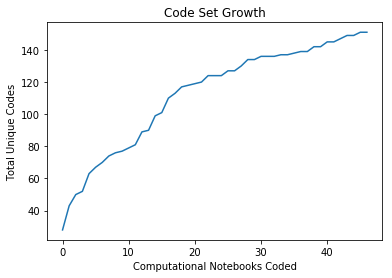

In [9]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

For each notebook included in analysis list which codes were introduced to the code set. After 23 notebooks, some computational notebooks didn't add any new codes.

In [10]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **2019-04-democratic-candidate-codonors**: calculate scaled ratio, count value frequency, union tables, create a semi-unique key, repetitive code, calculate ratio, group by multiple columns, peek at data, count unique values in column, sort table, sum along dimension, drop duplicate rows based on prior knowledge, change case, self join table, subset columns, annotate workflow, trim by contains value, export intermediate results, canonicalize column names, use open government data, compare different groups along a common metric, read as tabular data, outer join tables, remove with regular expression, architect a subroutine, group by single column, strip whitespace, gather table

2. **california-ccscore-analysis**: inspect table schema, calculate difference, create a crosstab, change column data type, split, compute, and merge, calculate z-score, count number of rows, drop duplicate rows based on values, trim by date range, visualize data, trim by quantitative threshold, calculate percentage difference, export results, calculate mean, format table display

3. **california-crop-production-wages-analysis**: architect repeating process, trim by geographic area, adjust for inflation, answer a question, construct table manually, inner join tables, wrangle data for graphics

4. **census-hard-to-map-analysis**: tolerate dirty data, slice column values

5. **long-term-care-db**: refine table, use non-public, provided data, fix data errors manually, encode table identification in row, aggregate the forest from the trees, fill in na values after an outer join, construct pivot table, scrape web for data, join with lookup table, drop erroneous rows, perform entity resolution manually

6. **2018-voter-registration**: create rolling window, pull tables out of pdf, show trend over time, calculate a statistic

7. **heat-index**: generate data computationally, compute index number, cartesian product

8. **2016-11-bellwether-counties**: use academic data, remove incomplete data, get extreme values, spread table

9. **2018-05-31-crime-and-heat-analysis**: combine seemingly disparate datasets, extract property from datetime

10. **2016-09-shy-trumpers**: use another news orgs data

11. **the-cube-root-law**: wtf, use public data

12. **2016-04-republican-donor-movements**: explore dynamic network flow, split column on delimiter

13. **california-h2a-visas-analysis**: replace na values, geocode addresses, temporary joining column, create child table, create a unique key, preserve existing values, cache results from external service, split and compute

14. **Endangered-Species-Act-Louisiana**: transform vector

15. **Power_of_Irma**: fix incorrect calculation, use previously cleaned data, outlier detection, interpret statistical/ml model, change date format, value replacement, use data from colleague, set data confidence threshold, toggle step on and off

16. **wikipedia-rankings**: explain variance, collect raw data

17. **babyname_politics**: resort after merge, get unique values, join aggregate, check results of previous operation, break ties, concatenate columns into key, assign ranks, data loss from aggregation, round floating point

18. **2015-11-refugees-in-the-united-states**: make an incorrect conclusion, test for equality, designate column as primary key

19. **employment-discrimination**: combine entities by string matching, concatenate files together, merge tables to create pivot table, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: data too large for repo, translate entity names manually, copy table schema, create flag

24. **buster-posey-mvp**: 

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: correct bad formatting, sort table rows, report rows with column number discrepancies

27. **prison-admissions**: 

28. **school-star-ratings-2018**: pad column values, display rows with missing values, reconcile primary keys between tables

29. **electric-car-charging-points**: define edge weights, find nearest neighbours in the network, encode redundant information, create edge

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality, freedom of information data

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices

35. **2018-voter-registration**: 

36. **2019-ems-analysis**: combine data and geography

37. **auditData**: combine columns

38. **lending-club**: 

39. **new-york-schools-assessment**: create lookup table, combine drifting datasets, backfill missing data

40. **skatemusic**: 

41. **awb-notebook**: summarize dataset, resolve by substring, silently dropping values after groupby

42. **201901-hospitalquality**: 

43. **general-election-2015-classification-tree**: wrangle data for model, check for nas

44. **201901-achievementgap**: bin values, query database

45. **school-choice**: 

46. **1805-regionen im fokus des US-praesidenten**: concat parallel tables, compute an inter-table column

47. **swana-population-map**: 

# Analysis Coverage

In order to prevent this code set from being biased by one individual or organization's data wrangling behavior, we deliberately sought out notebooks from a variety of news organizations and data journalists.

## Including the top-n news organizations

We include notebooks from news organizations making the largest contributions to data journalism. We ranked these organizations by two metrics: those with the most separate repositories and the most commits. News organizations such as *BuzzFeed News* and *Los Angeles Times* create one repo per analysis work flow. However, other organizations, such as *FiveThirtyEight*, consolidate all analysis workflows into one repo.

Add the repo count and commit count grouping the `repos` table created in `data/repos.csv` by organization. Then merge the repo counts and commit counts per organization to the `citations` data frame.

In [11]:
repos = pd.read_csv('data/repos.csv')

orgs = repos[repos.is_keeper == True] \
    .groupby('org') \
    .agg({
        'url': 'nunique',
        'commits': 'sum'
    }) \
    .reset_index() \
    .rename(columns={
        'org': 'organization', 
        'url': 'repo_count',
        'commits': 'commit_count'
    })

# Assign ranks to each organization per repo count and commit count
def rank(sort_col, rank_col):
    orgs.sort_values(sort_col, ascending=False, inplace=True)
    orgs[rank_col] = orgs.reset_index().index + 1

rank('repo_count', 'repo_rank')
rank('commit_count', 'commit_rank')

# Find which organizations have been included in analysis
includedOrgs = list(citations.organization.unique())
orgs['is_included'] = False
orgs.loc[orgs.organization.isin(includedOrgs), 'is_included'] = True

orgs

/opt/conda/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'commits'

### Top organizations by repository count

In [ ]:
sns.set(rc={'figure.figsize': (9,12)})
ax = sns.countplot(y='org',
              data=repos[repos.is_keeper],
              order=repos[repos.is_keeper].org.value_counts().index)  # Plot in descending order

ax.set_title('Most Prolific News Organizations by Repo Count')

In order for my theories to be represent the field in general and not the practices and quirks of an individual news organization, my analysis draws from articles by organizations that have a record of producing data journalism and those that only dabble in it. One way of determining which organizations are producing the most data journalism is by looking at which ones have the most repos from the list of relevant repos.


However, one limitation of using repo count is that some organizations, such as *FiveThirtyEight* keep computational notebooks for multiple data journalism articles in one repo.

A *commit* can be thought of as the atomic unit of change for a repo. Thus the more a repo has changed overtime, the more commits it will have. Therefore, if a news organization is only using one repo for all their data journalism work, then it should have lots of commits. 

I've mined commit totals for each repo by contributor to use contributor data later in this analysis.

In [ ]:
contributors = pd.read_csv('data/contributors.csv')
repos = pd.merge(repos, contributors, on='url', how='left')

sns.barplot(x='commits',
            y='org', 
            data=repos.groupby('org')['commits'].sum().to_frame('commits').reset_index() \
            .sort_values('commits', ascending=False) \
            .head(50)) \
    .set_title('Most Prolific News Organizations by Commit Count')

### So what is *n*?

In [ ]:
display(Markdown('Analysis includes the top {lowestRepo} and {lowestCommit} organizations by repo count and commit count, respectively.'.format(**{
    'lowestRepo': orgs[orgs.is_included == False].repo_rank.min() - 1,
    'lowestCommit': orgs[orgs.is_included == False].commit_rank.min() - 1
})))

### Which organizations were included?

In [ ]:
display(Markdown("""
    Organizations included in this analysis: \n * {}
""".format('\n * '.join(sorted(orgs[orgs.is_included == True].organization.unique())))))

## Including the top-n data journalists

In [ ]:
repos